In [1]:
# Install necessary libraries
! pip install --quiet \
  sentence_transformers==1.0.4 \

# Setup connection with your own google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Clone branch from github
!rm -rf policy-data-analyzer/
! branch_name='master' && \
  git clone --branch $branch_name https://github.com/wri-dssg/policy-data-analyzer.git

Cloning into 'policy-data-analyzer'...
remote: Enumerating objects: 6233, done.
remote: Counting objects: 100% (269/269), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 6233 (delta 147), reused 187 (delta 73), pack-reused 5964
Receiving objects: 100% (6233/6233), 206.72 MiB | 25.29 MiB/s, done.
Resolving deltas: 100% (3392/3392), done.
Checking out files: 100% (1004/1004), done.


In [3]:
#If you run this cell more than once, comment out this line because you are already in this folder and you will get an error
import os
os.chdir("policy-data-analyzer") 

from tasks.data_loading.src.utils import *
from sklearn.model_selection import train_test_split

In [4]:
"""
MAKE SURE THAT THIS IS ALWAYS YOUR INDIVIDUAL NUMBER (FOR REASONS TO NOT OVERWRITE DATA)
"""

GLOBAL_EXPERIMENT_NUMBER = 8

Please do not overwrite existing models and their results from previous experiments
You are writing to Experiment # 8


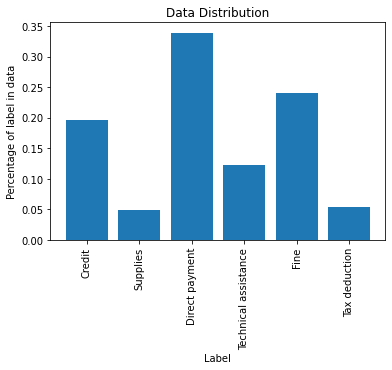

Label counts:
{'Credit': 0.19543147208121828, 'Supplies': 0.04949238578680203, 'Direct payment': 0.33883248730964466, 'Technical assistance': 0.1218274111675127, 'Fine': 0.24111675126903553, 'Tax deduction': 0.0532994923857868}


In [5]:
experiment = "EXP14"
classifier = "Multiclass"

base_path = "/content/drive/MyDrive/WRI-LatinAmerica-Talent"

data_path = f"{base_path}/Cristina_Policy_Files/Tagged_sentence_lists/Spanish/datasets/{classifier}"

results_save_path = f"{base_path}/Modeling/Model_reproducibility/Model_results/\
                                {classifier}ClassificationExperiments/{GLOBAL_EXPERIMENT_NUMBER}/"

if not os.path.exists(results_save_path):
    os.makedirs(results_save_path)
    print(f"Making new experiment folder for experiment # {GLOBAL_EXPERIMENT_NUMBER}")
else:
    print("Please do not overwrite existing models and their results from previous experiments")
    print(f"You are writing to Experiment # {GLOBAL_EXPERIMENT_NUMBER}")

train_sents, train_labels, test_sents, test_labels = load_dataset(data_path, experiment)
label_names = unique_labels(train_labels)
numeric_train_labels = labels2numeric(train_labels, label_names)
label2int = dict(zip(label_names, range(len(label_names))))
X_train, X_dev, y_train, y_dev = train_test_split(train_sents, train_labels, test_size=0.2,
                                                            stratify=train_labels, random_state=100)

plot_data_distribution(numeric_train_labels, label_names)

In [6]:
"""
This examples trains a CrossEncoder for the NLI task. A CrossEncoder takes a sentence pair
as input and outputs a label. Here, it learns to predict the labels: "contradiction": 0, "entailment": 1, "neutral": 2.
It does NOT produce a sentence embedding and does NOT work for individual sentences.
Usage:
python training_nli.py
"""

from torch.utils.data import DataLoader
import math
from sentence_transformers import LoggingHandler, util
from sentence_transformers.cross_encoder import CrossEncoder
from sentence_transformers.cross_encoder.evaluation import CEBinaryAccuracyEvaluator, CESoftmaxAccuracyEvaluator
from sentence_transformers.readers import InputExample
import logging
from datetime import datetime
import os
import gzip
import csv
from typing import List
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import numpy as np
from torch import device
import logging
from tqdm import tqdm
import os
import csv
from sklearn.metrics import f1_score, confusion_matrix
from sentence_transformers.evaluation import SentenceEvaluator
import itertools
from typing import Dict

In [8]:
def plot_confusion_matrix(cm, label_names, title='Confusion matrix',
                          color_map=None,
                          normalize=True,
                          output_path=None):
    """
    Adapted from: https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels
    """
    if color_map is None:
        color_map = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=color_map)

    plt.title(title)
    plt.colorbar()
    plt.style.use('seaborn-white')

    if label_names:
        tick_marks = np.arange(len(label_names))
        plt.xticks(tick_marks, label_names, rotation=45)
        plt.yticks(tick_marks, label_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    if output_path:
        fname = f"{output_path}_cm.png"
        plt.savefig(fname)
        print(f"Stored confusion matrix: {fname}")

    plt.show()

In [9]:
class CustomCESoftmaxAccuracyEvaluator:
    """
    This evaluator can be used with the CrossEncoder class.
    It is designed for CrossEncoders with 2 or more outputs. It measure the
    accuracy of the predict class vs. the gold labels.

    ADDED: F1 score
    """
    def __init__(self, sentence_pairs: List[List[str]], labels: List[int], name: str='', label_names: list = None, write_csv: bool = True):
        self.sentence_pairs = sentence_pairs
        self.labels = labels
        self.name = name
        self.label_names = label_names

        self.csv_file = "CESoftmaxAccuracyEvaluator" + ("_" + name if name else '') + "_results.csv"
        self.csv_headers = ["epoch", "steps", "Accuracy"]
        self.write_csv = write_csv

    @classmethod
    def from_input_examples(cls, examples: List[InputExample], **kwargs):
        sentence_pairs = []
        labels = []

        for example in examples:
            sentence_pairs.append(example.texts)
            labels.append(example.label)
        return cls(sentence_pairs, labels, **kwargs)

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        if epoch != -1:
            if steps == -1:
                out_txt = " after epoch {}:".format(epoch)
            else:
                out_txt = " in epoch {} after {} steps:".format(epoch, steps)
        else:
            out_txt = ":"

        logger.info("CESoftmaxAccuracyEvaluator: Evaluating the model on " + self.name + " dataset" + out_txt)
        pred_scores = model.predict(self.sentence_pairs, convert_to_numpy=True, show_progress_bar=False)
        pred_labels = np.argmax(pred_scores, axis=1)

        assert len(pred_labels) == len(self.labels)

        acc = np.sum(pred_labels == self.labels) / len(self.labels)

        logger.info("Accuracy: {:.2f}".format(acc*100))
        
        cm = confusion_matrix(self.labels, pred_labels)
        macro_f1 = f1_score(self.labels, pred_labels, average='macro')
        weighted_f1 = f1_score(self.labels, pred_labels, average='weighted')
        logging.info(f"Macro F1: {macro_f1}")
        logging.info(f"Weighted F1: {weighted_f1}")
        plot_confusion_matrix(cm, self.label_names)

        if output_path is not None and self.write_csv:
            csv_path = os.path.join(output_path, self.csv_file)
            output_file_exists = os.path.isfile(csv_path)
            with open(csv_path, mode="a" if output_file_exists else 'w', encoding="utf-8") as f:
                writer = csv.writer(f)
                if not output_file_exists:
                    writer.writerow(self.csv_headers)

                writer.writerow([epoch, steps, acc])

        return acc

### Train using basic multilingual BERT

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model 

2021-04-28 05:11:48 - Use pytorch device: cuda
2021-04-28 05:11:48 - Warmup-steps: 80



2021-04-28 05:12:01 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 0:
2021-04-28 05:12:02 - Accuracy: 41.14
2021-04-28 05:12:02 - Macro F1: 0.16570154691025749
2021-04-28 05:12:02 - Weighted F1: 0.2944501398382646


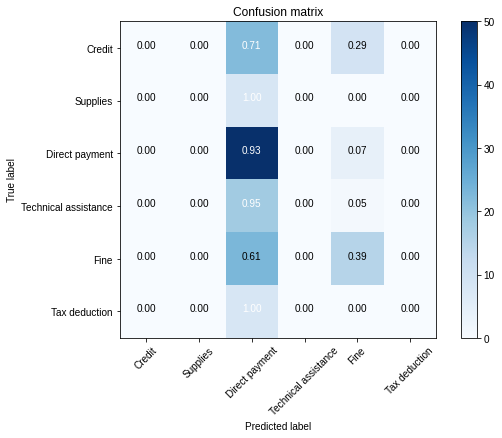


2021-04-28 05:12:13 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 1:
2021-04-28 05:12:14 - Accuracy: 46.84
2021-04-28 05:12:14 - Macro F1: 0.20213329647291914
2021-04-28 05:12:14 - Weighted F1: 0.3477325158719952


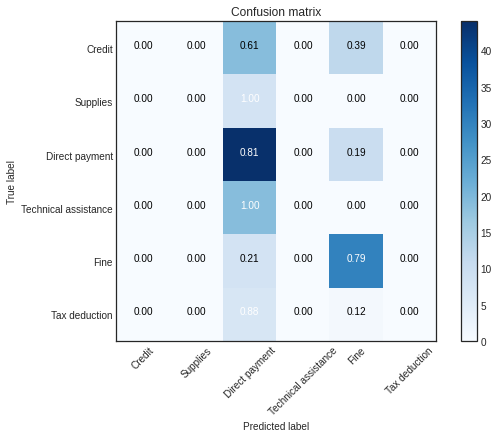


2021-04-28 05:12:24 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 2:
2021-04-28 05:12:25 - Accuracy: 63.29
2021-04-28 05:12:25 - Macro F1: 0.3720616167424678
2021-04-28 05:12:25 - Weighted F1: 0.5651005288764513


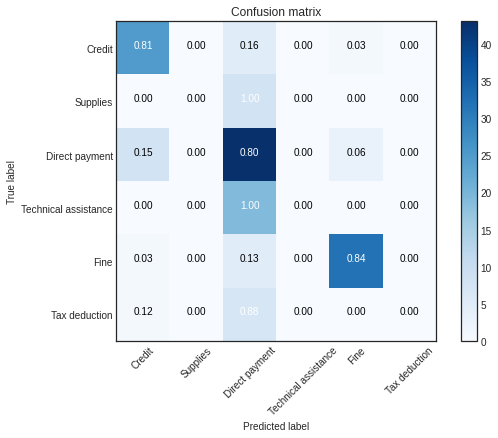


2021-04-28 05:12:36 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 3:
2021-04-28 05:12:37 - Accuracy: 75.95
2021-04-28 05:12:37 - Macro F1: 0.5254982363315697
2021-04-28 05:12:37 - Weighted F1: 0.7190491259795055


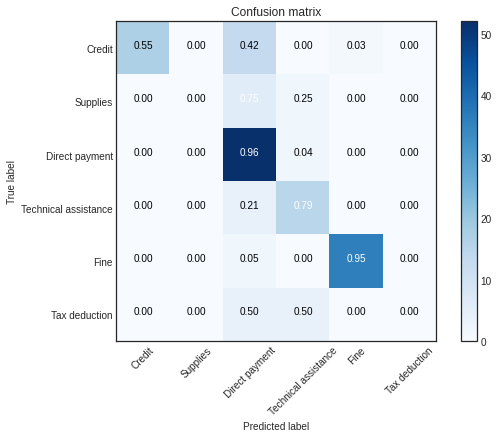


2021-04-28 05:12:48 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 4:
2021-04-28 05:12:49 - Accuracy: 80.38
2021-04-28 05:12:49 - Macro F1: 0.555117334364503
2021-04-28 05:12:49 - Weighted F1: 0.7690396747687669


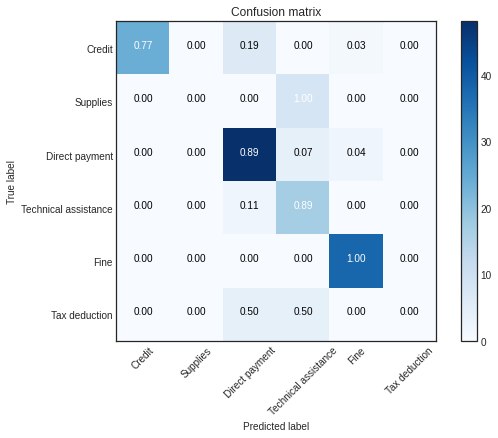


2021-04-28 05:12:59 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 5:
2021-04-28 05:13:00 - Accuracy: 81.65
2021-04-28 05:13:00 - Macro F1: 0.5656952318988754
2021-04-28 05:13:00 - Weighted F1: 0.7823794679991198


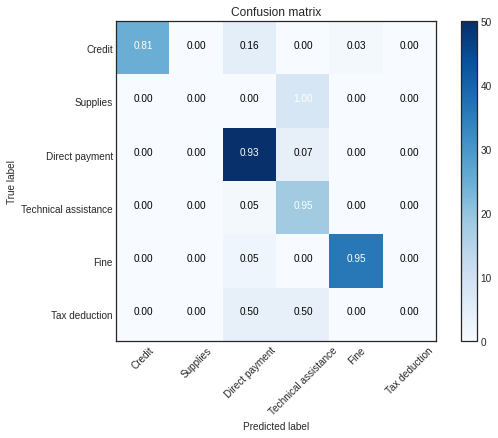


2021-04-28 05:13:11 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 6:
2021-04-28 05:13:12 - Accuracy: 81.01
2021-04-28 05:13:12 - Macro F1: 0.5627098702870028
2021-04-28 05:13:12 - Weighted F1: 0.7802044420006009


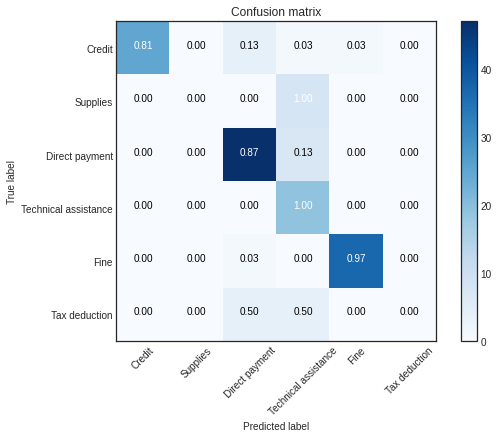


2021-04-28 05:13:23 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 7:
2021-04-28 05:13:24 - Accuracy: 81.01
2021-04-28 05:13:24 - Macro F1: 0.5616260478783165
2021-04-28 05:13:24 - Weighted F1: 0.780049261083744


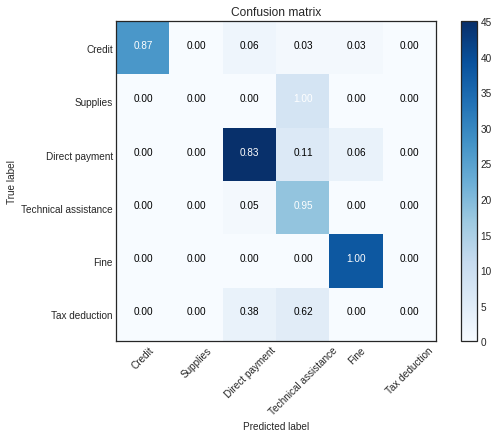


2021-04-28 05:13:34 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 8:
2021-04-28 05:13:35 - Accuracy: 83.54
2021-04-28 05:13:35 - Macro F1: 0.6491237332058898
2021-04-28 05:13:35 - Weighted F1: 0.8127821237114229


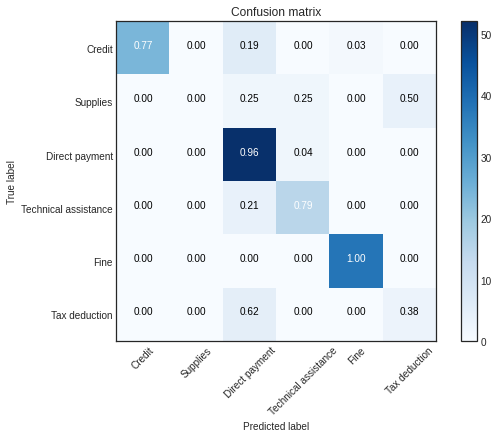


2021-04-28 05:13:46 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 9:
2021-04-28 05:13:46 - Accuracy: 86.08
2021-04-28 05:13:46 - Macro F1: 0.7791220475431002
2021-04-28 05:13:46 - Weighted F1: 0.8628008456123047


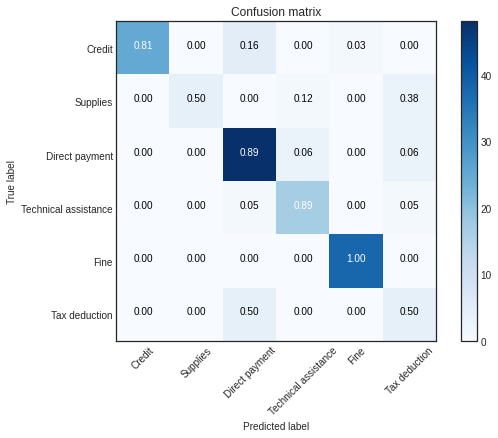


2021-04-28 05:13:57 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 10:
2021-04-28 05:13:58 - Accuracy: 89.24
2021-04-28 05:13:58 - Macro F1: 0.8466400151509074
2021-04-28 05:13:58 - Weighted F1: 0.8898569269649206


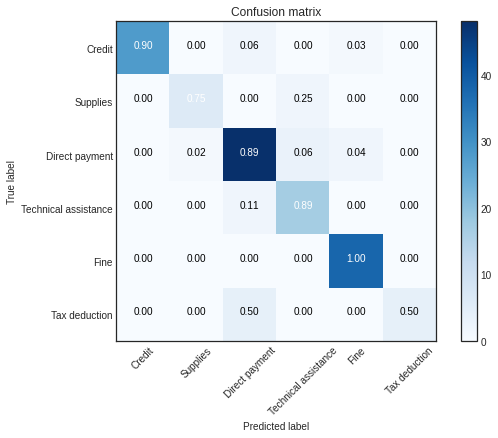


2021-04-28 05:14:09 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 11:
2021-04-28 05:14:10 - Accuracy: 85.44
2021-04-28 05:14:10 - Macro F1: 0.7972279507367226
2021-04-28 05:14:10 - Weighted F1: 0.8525744679975195


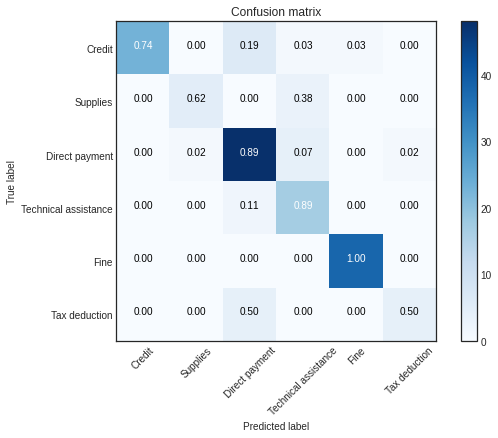


2021-04-28 05:14:20 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 12:
2021-04-28 05:14:21 - Accuracy: 87.97
2021-04-28 05:14:21 - Macro F1: 0.8526287980565267
2021-04-28 05:14:21 - Weighted F1: 0.8784718615008746


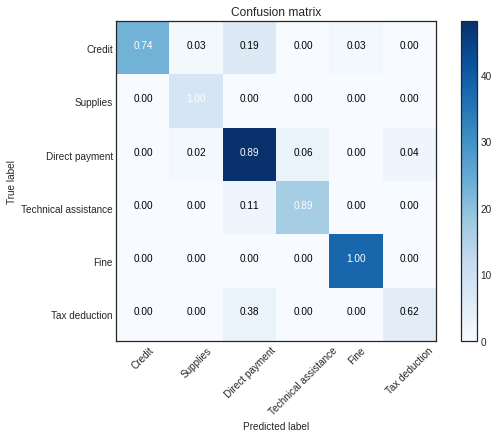


2021-04-28 05:14:31 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 13:
2021-04-28 05:14:32 - Accuracy: 87.97
2021-04-28 05:14:32 - Macro F1: 0.8423133259216473
2021-04-28 05:14:32 - Weighted F1: 0.8797986434743423


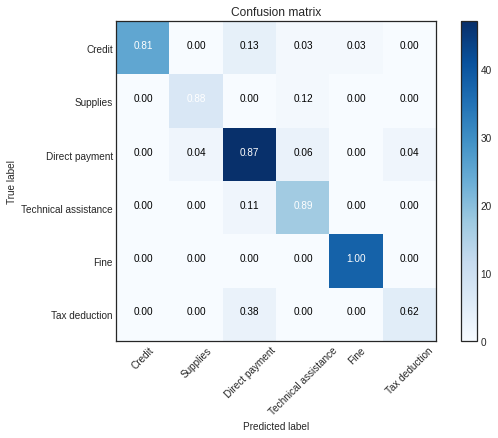


2021-04-28 05:14:43 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 14:
2021-04-28 05:14:44 - Accuracy: 89.87
2021-04-28 05:14:44 - Macro F1: 0.8434482206057389
2021-04-28 05:14:44 - Weighted F1: 0.8975275466096233


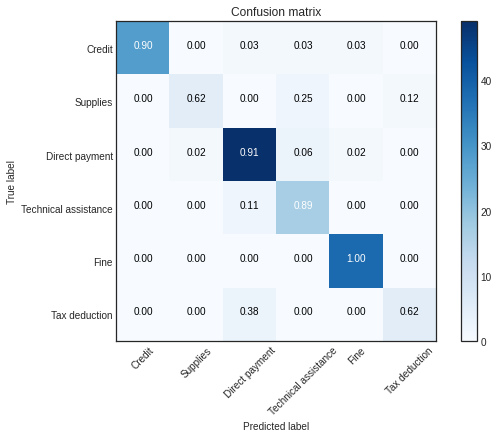


2021-04-28 05:14:55 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 15:
2021-04-28 05:14:56 - Accuracy: 87.97
2021-04-28 05:14:56 - Macro F1: 0.8495188179857623
2021-04-28 05:14:56 - Weighted F1: 0.8790485200261556


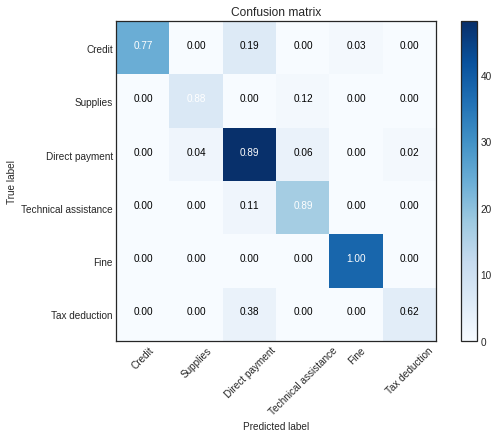


2021-04-28 05:15:06 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 16:
2021-04-28 05:15:07 - Accuracy: 89.87
2021-04-28 05:15:07 - Macro F1: 0.8609774722431806
2021-04-28 05:15:07 - Weighted F1: 0.8986507219551435


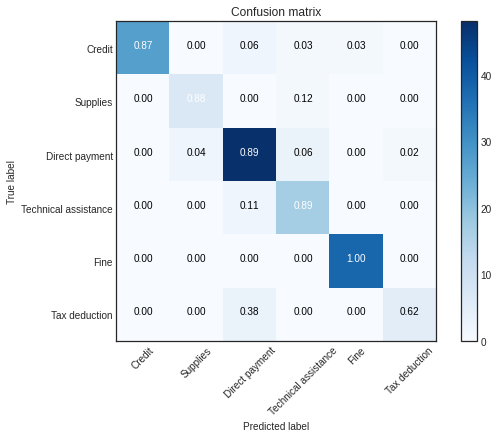


2021-04-28 05:15:18 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 17:
2021-04-28 05:15:19 - Accuracy: 90.51
2021-04-28 05:15:19 - Macro F1: 0.8653563061680174
2021-04-28 05:15:19 - Weighted F1: 0.9049926638571633


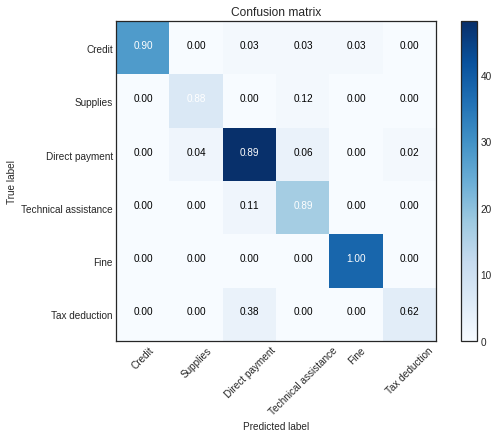


2021-04-28 05:15:29 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 18:
2021-04-28 05:15:30 - Accuracy: 90.51
2021-04-28 05:15:30 - Macro F1: 0.8653563061680174
2021-04-28 05:15:30 - Weighted F1: 0.9049926638571633


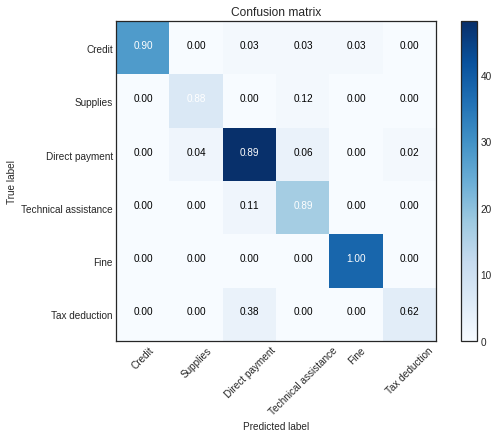


2021-04-28 05:15:41 - CESoftmaxAccuracyEvaluator: Evaluating the model on EXP14 dataset after epoch 19:
2021-04-28 05:15:42 - Accuracy: 90.51
2021-04-28 05:15:42 - Macro F1: 0.8653563061680174
2021-04-28 05:15:42 - Weighted F1: 0.9049926638571633


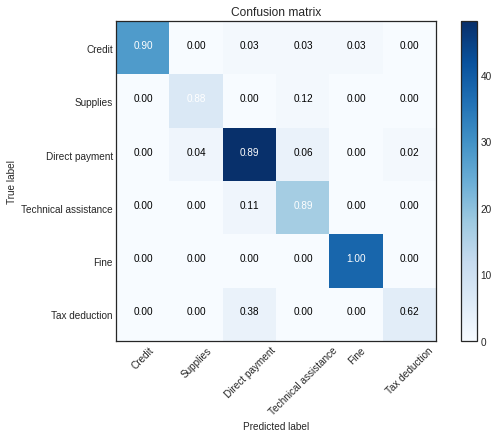

In [10]:
#### Just some code to print debug information to stdout
logging.basicConfig(format='%(asctime)s - %(message)s',
                    datefmt='%Y-%m-%d %H:%M:%S',
                    level=logging.INFO,
                    handlers=[LoggingHandler()])
logger = logging.getLogger(__name__)
#### /print debug information to stdout

train_samples = []
for sent, label in zip(X_train, y_train):
    label_id = label2int[label]
    train_samples.append(InputExample(texts=[sent, sent], label=label_id))

dev_samples = []
for sent, label in zip(X_dev, y_dev):
    label_id = label2int[label]
    dev_samples.append(InputExample(texts=[sent, sent], label=label_id))

train_batch_size = 16
num_epochs = 20
# model_save_path = 'output/training_allnli-'+datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#Define our CrossEncoder model. We use distilroberta-base as basis and setup it up to predict 3 labels
model = CrossEncoder('bert-base-multilingual-uncased', num_labels=len(label2int))

#We wrap train_samples, which is a list ot InputExample, in a pytorch DataLoader
train_dataloader = DataLoader(train_samples, shuffle=True, batch_size=train_batch_size)

#During training, we use CESoftmaxAccuracyEvaluator to measure the accuracy on the dev set.
evaluator = CustomCESoftmaxAccuracyEvaluator.from_input_examples(dev_samples, name=experiment, label_names=label_names)

warmup_steps = math.ceil(len(train_dataloader) * num_epochs * 0.1) #10% of train data for warm-up
logger.info("Warmup-steps: {}".format(warmup_steps))


# Train the model
model.fit(train_dataloader=train_dataloader,
          evaluator=evaluator,
          epochs=num_epochs,
          evaluation_steps=10000,
          warmup_steps=warmup_steps)
          # output_path=model_save_path)


### Evaluate on test set

In [11]:
test_sents[0], test_labels[0]

('- el Estado promovera lineas de credito preferenciales para La reactivacion y promocion de La pesca y La acuicultura nacional',
 'Credit')

In [22]:
# Create a sentence pair for each sentence because of crossencoder input architecture
dup_test_sents = [[sent, sent] for sent in test_sents]

In [23]:
preds = np.argmax(model.predict(dup_test_sents), axis=1)

In [28]:
numeric_test_labels = labels2numeric(test_labels, label_names)

Accuracy: 89.39
Macro F1: 0.8523674579382122
Weighted F1: 0.8920958957476198


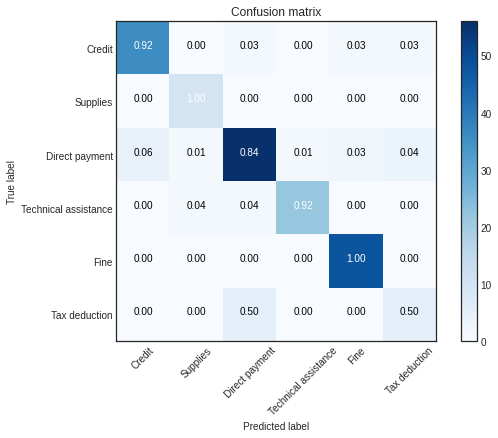

In [29]:
acc = np.sum(preds == numeric_test_labels) / len(numeric_test_labels)
macro_f1 = f1_score(numeric_test_labels, preds, average='macro')
weighted_f1 = f1_score(numeric_test_labels, preds, average='weighted')
cm = confusion_matrix(numeric_test_labels, preds)

print("Accuracy: {:.2f}".format(acc*100))
print(f"Macro F1: {macro_f1}")
print(f"Weighted F1: {weighted_f1}")
plot_confusion_matrix(cm, label_names)